# Description

name // 
citation

## Load libraries

In [1]:
import vit_prisma
import nltk
from nltk.corpus import wordnet as wn
from datasets import load_dataset

from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import torch

import matplotlib.pyplot as plt

nltk.download('wordnet')

import numpy as np
from fancy_einsum import einsum

[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>


## Load dataset

We'll load a downsampled subset of ImageNet-1k.

ImageNet-1k's 1000 classes is the closest thing we'll have to a "dictionary" for this notebook. Note that the dictionary is flexible; e.g. if we were using CLIP, we would have a more expansive dictionary than 1000 classes.

(Optional) Technical note on dataset:
Annoyingly the dataset has two labels: the original ImageNet label, and the dataset's own label. We're using a trimmed down version of the ImageNet that only has a subset of classes. For the purposes of this notebook, I'll try to stick with original ImageNet labels and be explicit when using the dataset labels.

In [2]:
# we'll use a subset of imagenet
dataset = load_dataset("zh-plus/tiny-imagenet")

In [3]:


class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

# Define your transformations, including the custom ConvertTo3Channels
transform = transforms.Compose([
    ConvertTo3Channels(),  # Ensure all images are 3-channel without turning them grayscale
    transforms.Resize((224, 224)),  # Resize images to a common size.
    transforms.ToTensor(),  # Convert images to tensor.
    # You can include normalization if desired, using correct values for 3-channel images.
])

def transform_batch(examples):
    images = [transform(image) for image in examples['image']]
    labels = torch.tensor(examples['label'])
    return {'image': images, 'label': labels}



# Apply transformations to the dataset
dataset.set_transform(transform_batch)

# Create PyTorch DataLoader
batch_size = 2
train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset['valid'], batch_size=batch_size)

# Now, you can use train_loader and valid_loader in your training loop.


In [4]:
# # Catlike things
# n02123045 ['tabby', 'tabby_cat']
# n02123394 ['Persian_cat']
# n02124075 ['Egyptian_cat']
# n02125311 ['cougar', 'puma', 'catamount', 'mountain_lion', 'painter', 'panther', 'Felis_concolor']
# n02129165 ['lion', 'king_of_beasts', 'Panthera_leo']

### Imagenet helper functions

In [5]:
def map_dataset_idx_to_imagenet_idx(subset_index):
    synset = get_wordnet_synset(subset_index)
    word = get_wordnet_name(synset)[0]
    word = word.replace('_', ' ').lower()
    imagenet_index = imagenet_index_from_word(word)
    return imagenet_index

In [6]:
def get_wordnet_synset(index):
    return dataset['train'].features['label'].names[index]

def get_wordnet_name(synset_id):
    # Make sure you have the wordnet data installed


    # Convert the synset ID to a format NLTK understands (remove 'n' and zero-pad)
    offset = int(synset_id[1:])
    wn_id = f"n{str(offset).zfill(8)}"

    # Look up the synset
    synset = wn.synset_from_pos_and_offset('n', offset)

    # Print out the synset's lemma names (the words associated with this synset)
    names = synset.lemma_names()
    return names

def get_wordnet_name_from_dataset_idx(index):
    synset = get_wordnet_synset(index)
    name = get_wordnet_name(synset)
    return name

def get_index_from_synset(synset):
    return dataset['train'].features['label'].names.index(synset)

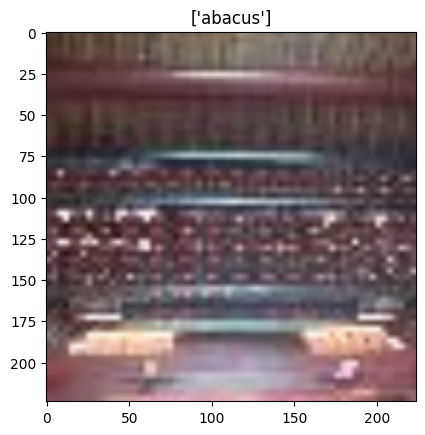

In [7]:
data = next(iter(train_loader))
image, label = data['image'], data['label']

plt.title(get_wordnet_name(get_wordnet_synset(label[1])))
plt.imshow(image[1].permute(1,2,0))



## Load model

In [8]:
import importlib
import vit_prisma




In [9]:
# We'll use a vanilla vision transformer
from vit_prisma.models.base_vit import HookedViT
prisma_model = HookedViT.from_pretrained("vit_base_patch32_224", 
                                        center_writing_weights=True, 
                                        center_unembed=True,
                                        fold_ln=True,
                                        refactor_factored_attn_matrices=True,
                                    )

{'n_layers': 12, 'd_model': 768, 'd_head': 64, 'model_name': 'timm/vit_base_patch32_224.augreg_in21k_ft_in1k', 'n_heads': 12, 'd_mlp': 3072, 'activation_name': 'gelu', 'eps': 1e-06, 'original_architecture': 'vit_base_patch32_224', 'initializer_range': 0.02, 'n_channels': 3, 'patch_size': 32, 'image_size': 224, 'n_classes': 1000, 'n_params': 88224232, 'return_type': 'class_logits'}
LayerNorm folded.
Centered weights writing to residual stream
Centering the output weights...
Loaded pretrained model vit_base_patch32_224 into HookedTransformer


In [10]:
def find_cats(data_loader, cat_label, cat_count=6):
    cat_images = []  # List to store images containing cats
    cat_labels = []  # List to store labels of the images (for verification)
    
    count = 0
    for batch in data_loader:
        images, labels = batch['image'], batch['label']
                
        
        # Find indices of images that are labeled as cats
        cat_indices = [index for index, label in enumerate(labels) if label == cat_label]
        
        # Append the cat images and labels to their respective lists
        for index in cat_indices:
            cat_images.append(images[index])
            cat_labels.append(labels[index])
            count += 1
            
            if count >= cat_count:
                break
            
        
        if count >= cat_count:
            break
    
    return cat_images, cat_labels

# Example usage with the training dataset DataLoader
tabby_syn = 'n02123045'
cat_images_train, cat_labels_train = find_cats(train_loader, cat_label = get_index_from_synset(tabby_syn))

In [11]:
len(cat_images_train)

6

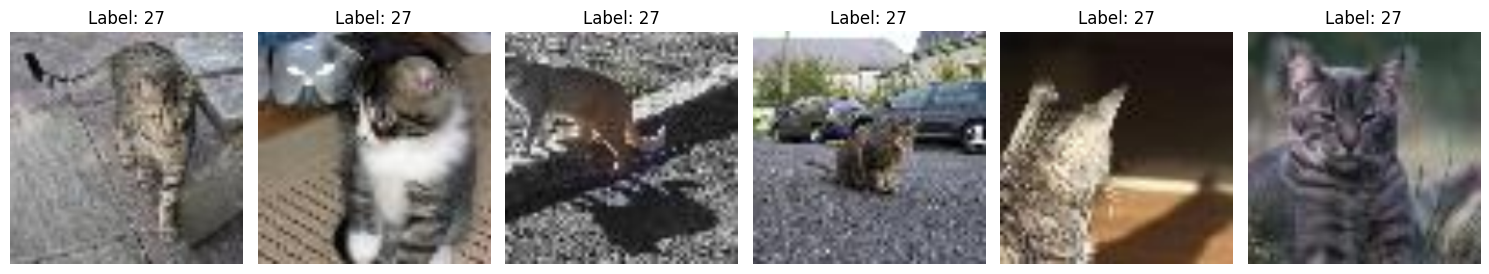

In [12]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

def show_image(tensor):
    """
    Converts a tensor to a PIL image and displays it.
    """
    # Convert the tensor to a PIL image using ToPILImage transform
    to_pil_image = T.ToPILImage()
    img = to_pil_image(tensor)
    plt.imshow(img)
    plt.axis('off')  # Don't show axes for images

# Display the first few cat images
fig = plt.figure(figsize=(15, 6))
for i, tensor in enumerate(cat_images_train[:6], start=1):
    ax = fig.add_subplot(1, 6, i)
    show_image(tensor)
    ax.set_title(f"Label: {cat_labels_train[i-1]}")
plt.tight_layout()
plt.show()

In [13]:
def get_wordnet_synset(index):
    return dataset['train'].features['label'].names[index]

print(dataset['train'].features['label'].names)

['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02165456', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495', 'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666347', 'n02669723', 'n02699494', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n02808440', 'n02814533', 'n02814860', 'n02815834', 'n02823428', 'n02837789', 'n02841315', 'n02843684', 'n02883205', 'n02892201', 'n02909870', 'n02917067', 'n02927161', 'n02948072'

## Inspect logits

### Print logits

Find the logits for tabby cat

In [14]:
from vit_prisma.utils.data_utils.imagenet_dict import IMAGENET_DICT


In [15]:
example_prompt = cat_images_train[0]
example_answer = 'tabby cat'

In [16]:
def imagenet_index_from_word(search_term):
    # Convert the search term to lowercase to ensure case-insensitive matching
    search_term = search_term.lower()

    # Iterate over the dictionary and search for the term
    for key, value in IMAGENET_DICT.items():
        if search_term in value.lower():  # Convert each value to lowercase for case-insensitive comparison
            return key  # Return the key directly once found

    # If the loop completes without returning, the term was not found; raise an exception
    raise ValueError(f"'{search_term}' not found in IMAGENET_DICT.")
    

def test_prompt(example_prompt, example_answer, model, top_k=10):

    logits = model(example_prompt.unsqueeze(0)) 
    probs = logits.softmax(dim=-1)
    probs = probs.squeeze(0).detach().numpy()
    sorted_probs = np.sort(probs)[::-1]
    sorted_probs_args = np.argsort(probs)[::-1]

    for i in range(top_k):
        index = sorted_probs_args[i]
        prob = sorted_probs[i]
        logit = logits[0, index].item()  # Assuming you want to show the original logit value
        label = IMAGENET_DICT[index]  # Adjust based on your mapping

        rank_str = f"Top {i}th token."
        logit_str = f"Logit: {logit:.2f}"
        prob_str = f"Prob: {prob * 100:.2f}%"
        token_str = f"Label: |{label}|"

        print(f"{rank_str} {logit_str} {prob_str} {token_str}")


    tabby_cat_idx = imagenet_index_from_word(example_answer)
        
    # Example for displaying ranks of the answer tokens, adjust according to your needs
    answer_index = imagenet_index_from_word(example_answer)
    answer_indices = [answer_index]  # Assuming index is the answer index, adjust as necessary
    print("Rank of the correct answer:")
    for ans_index in answer_indices:
        rank = np.where(sorted_probs_args == ans_index)[0][0]
        print(f"Class Name: {example_answer} | Rank: {rank} | ImageNet Index: {tabby_cat_idx}")

test_prompt(example_prompt, 'tabby cat', prisma_model)


Top 0th token. Logit: 11.18 Prob: 68.23% Label: |Egyptian cat|
Top 1th token. Logit: 9.42 Prob: 11.76% Label: |tiger cat|
Top 2th token. Logit: 9.32 Prob: 10.70% Label: |tabby, tabby cat|
Top 3th token. Logit: 7.23 Prob: 1.31% Label: |fire screen, fireguard|
Top 4th token. Logit: 7.17 Prob: 1.25% Label: |snow leopard, ounce, Panthera uncia|
Top 5th token. Logit: 7.15 Prob: 1.21% Label: |lynx, catamount|
Top 6th token. Logit: 5.56 Prob: 0.25% Label: |plastic bag|
Top 7th token. Logit: 5.53 Prob: 0.24% Label: |leopard, Panthera pardus|
Top 8th token. Logit: 5.33 Prob: 0.20% Label: |tiger, Panthera tigris|
Top 9th token. Logit: 5.04 Prob: 0.15% Label: |Persian cat|
Rank of the correct answer:
Class Name: tabby cat | Rank: 2 | ImageNet Index: 281


### Get Logit difference

Things get a bit tricky here. Between tabby cat and non-cat? Between all classes of cats (tabby cats, tiger cats, Egyptian cats, and Persian cats), and non-cats? What about big cats like lynxes and polecats and lions?

A more principled way would be to set a neighborhood of points around the tabby_cat embedding in semantic space and create a tabby cat l-norm ball. However, this is a pending research topic and out of scope for the current demo. So we'll just do tabby cat vs non-tabby cat for now. In the future, we may cluster all the cats together for predictions that are more coarse-grained.

For the non-cat, we'll pick random non-cat objects. We'll avoid cat-like classes for cleanness. This is not necessarily the most principled way of picking a non-cat point in semantic space but good enough for our current purposes.

In [17]:
def find_non_cats(data_loader, cat_count=6):
    non_cat_images = []  # List to store images not containing cats
    non_cat_labels = []  # List to store labels of the images (for verification)
    
    count = 0
    for batch in data_loader:
        images, labels = batch['image'], batch['label']
                
        # Find indices of images that are not labeled as cats
        non_cat_indices = [index for index, label in enumerate(labels) if all('cat' not in name.lower() for name in get_wordnet_name_from_dataset_idx(label))
                          ]
        
        # Append the non-cat images and labels to their respective lists
        for index in non_cat_indices:
            non_cat_images.append(images[index])
            non_cat_labels.append(labels[index])
            count += 1
            
            if count >= cat_count:
                break
        
        if count >= cat_count:
            break
    
    return non_cat_images, non_cat_labels

# Example usage with the training dataset DataLoader
# Assuming 'train_loader' is your DataLoader instance and IMAGENET_DICT is a dictionary mapping labels to names
non_cat_images_train, non_cat_labels_train = find_non_cats(train_loader)

print(len(non_cat_images_train))

6


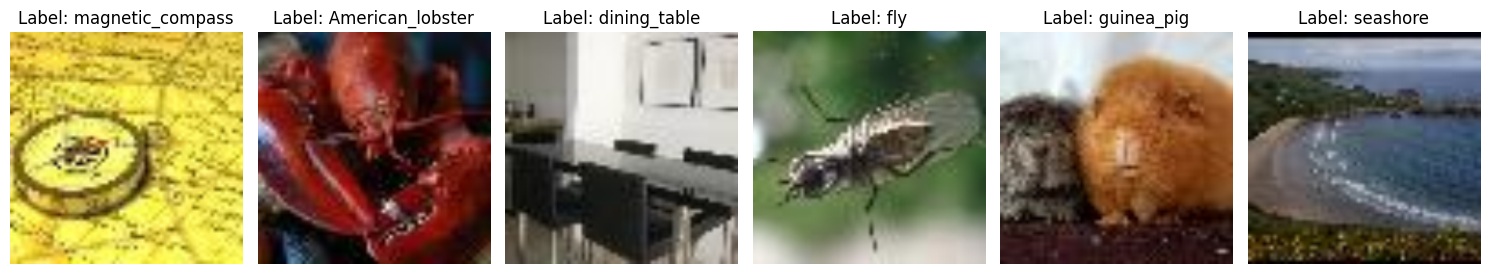

In [18]:
# Put in cat aand non-cat pairs
import matplotlib.pyplot as plt
import torchvision.transforms as T

def show_image(tensor):
    """
    Converts a tensor to a PIL image and displays it.
    """
    # Convert the tensor to a PIL image using ToPILImage transform
    to_pil_image = T.ToPILImage()
    img = to_pil_image(tensor)
    plt.imshow(img)
    plt.axis('off')  # Don't show axes for images

# Display the first few cat images
fig = plt.figure(figsize=(15, 6))
for i, tensor in enumerate(non_cat_images_train, start=1):
    ax = fig.add_subplot(1, 6, i)
    show_image(tensor)
    ax.set_title(f"Label: {get_wordnet_name_from_dataset_idx(non_cat_labels_train[i-1])[0]}")
plt.tight_layout()
plt.show()

In [19]:
# reshape image list into a batch
cat_images = torch.stack(cat_images_train)
non_cat_images = torch.stack(non_cat_images_train)

In [20]:
# Run model and cache activations
original_logits, cache = prisma_model.run_with_cache(cat_images)

original_logits.shape


torch.Size([6, 1000])

In [21]:
for i, l in zip(cat_images_train, cat_labels_train):
    word_label = get_wordnet_name_from_dataset_idx(l)[0]
    test_prompt(i, word_label, prisma_model)
    print('\n')

Top 0th token. Logit: 11.18 Prob: 68.23% Label: |Egyptian cat|
Top 1th token. Logit: 9.42 Prob: 11.76% Label: |tiger cat|
Top 2th token. Logit: 9.32 Prob: 10.70% Label: |tabby, tabby cat|
Top 3th token. Logit: 7.23 Prob: 1.31% Label: |fire screen, fireguard|
Top 4th token. Logit: 7.17 Prob: 1.25% Label: |snow leopard, ounce, Panthera uncia|
Top 5th token. Logit: 7.15 Prob: 1.21% Label: |lynx, catamount|
Top 6th token. Logit: 5.56 Prob: 0.25% Label: |plastic bag|
Top 7th token. Logit: 5.53 Prob: 0.24% Label: |leopard, Panthera pardus|
Top 8th token. Logit: 5.33 Prob: 0.20% Label: |tiger, Panthera tigris|
Top 9th token. Logit: 5.04 Prob: 0.15% Label: |Persian cat|
Rank of the correct answer:
Class Name: tabby | Rank: 2 | ImageNet Index: 281


Top 0th token. Logit: 11.27 Prob: 68.22% Label: |tabby, tabby cat|
Top 1th token. Logit: 9.30 Prob: 9.48% Label: |tiger cat|
Top 2th token. Logit: 9.04 Prob: 7.33% Label: |plastic bag|
Top 3th token. Logit: 8.68 Prob: 5.13% Label: |Egyptian cat|
Top

I'm thinking randomly picking images doesn't make sense, can actually plot out numbers in semantic space.

Instead, you can create a manifold

You can use the manifold to approximate the semantic space of the net

In [35]:
# The per prompt difference doesn't really make sense here in the same way
def logit_difference(logits, labels, per_prompt=True):
    answer_logits = logits.gather(dim=-1, index=labels)
    answer_logit_diff = answer_logits[:,0] - answer_logits[:,1]
    if per_prompt:
        return answer_logit_diff.detach()
    else:
        return answer_logit_diff.mean()
    
target_labels = [map_dataset_idx_to_imagenet_idx(int(x)) for x in cat_labels_train] # may need to remap to ImageNet index 
non_target_labels = [map_dataset_idx_to_imagenet_idx(int(x)) for x in non_cat_labels_train] # may need to remap to ImageNet index 

paired_labels = [[a, b] for a, b in zip(target_labels, non_target_labels)]
paired_labels = torch.Tensor(paired_labels).long()


per_prompt = logit_difference(original_logits, paired_labels)
print("per prompt:", per_prompt)

average = logit_difference(original_logits, paired_labels, per_prompt=False)
print("average:", average.item())


per prompt: tensor([ 8.1125, 10.8393,  5.2711,  6.0513,  6.2052,  7.4171])
average: 7.316104412078857


## Direct logit attribution

In [41]:
import importlib
import einops
import vit_prisma

# Tokens to residual directions

print(prisma_model.head.weight.T.shape)


answer_residual_directions = prisma_model.head.weight.T[:,paired_labels] + prisma_model.head.bias[paired_labels]
print(answer_residual_directions.shape)
# answer_residual_directions = einops.rearrange(
#                 answer_residual_directions, "d_model ... -> ... d_model"
#             )
# print(answer_residual_directions.shape)

logit_diff_directions = answer_residual_directions[:, :, 0] - answer_residual_directions[:, :, 1]
print(logit_diff_directions.shape)

# rearrange
logit_diff_directions = einops.rearrange(
                logit_diff_directions, "d_model ... -> ... d_model"
            )

print(logit_diff_directions.shape)

torch.Size([768, 1000])
torch.Size([768, 6, 2])
torch.Size([768, 6])
torch.Size([6, 768])


In [51]:
final_residual_stream = cache["resid_post", -1]
print("Final residual stream shape", final_residual_stream.shape)

# Put 0 to get CLS token at beginning
cls_token_residual_stream = final_residual_stream[:, 0, :]
scaled_final_token_residual_stream = cache.apply_ln_to_stack(
    cls_token_residual_stream, layer=-1, pos_slice=0 # Check this
)

print("scaled final token shape:", scaled_final_token_residual_stream.shape)

# print(scaled_final_token_residual_stream @ logit_diff_directions)

elementwise_product = cls_token_residual_stream @ logit_diff_directions.T

# get diagonal
diagonal = elementwise_product.diag()
print("diagonal", diagonal)

# average_logit_diff = einsum(
#     "batch d_model, batch d_model -> ",
#     scaled_final_token_residual_stream,
#     logit_diff_directions,
# ) 

# average_logit_diff /=  6
print("mean of diagonal:", diagonal.mean())

Final residual stream shape torch.Size([6, 50, 768])
scaled final token shape: torch.Size([6, 768])
diagonal tensor([12.6957, 14.2311,  3.6852,  5.5776,  8.9189, 10.2042],
       grad_fn=<DiagonalBackward0_copy>)
mean of diagonal: tensor(9.2188, grad_fn=<MeanBackward0>)


In [25]:
answer_residual_directions = prisma_model.tokens_to_residual_directions(paired_labels)


In [26]:
accumulated_residual, labels = cache.accumulated_resid(
    layer=-1, incl_mid=True, return_labels=True 
)
print(accumulated_residual.shape) # layer x batch x patch_num x model_dim


torch.Size([25, 6, 50, 768])


## Logit lens

## Layer attribution

## Head attribution

## Attention analysis

## Activation patching

## Residual stream

## Layers

## Heads

## Decomposing heads

## Consolidating understanding

## Random fun things